In [9]:
import imageio as io
import matplotlib.pyplot as plt
import numpy as np
import sys
img = io.imread('./data/img/bed.png')

C:\Users\nkhalil\AppData\Local\Temp\ipykernel_15880\1254488546.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = io.imread('./data/img/bed.png')


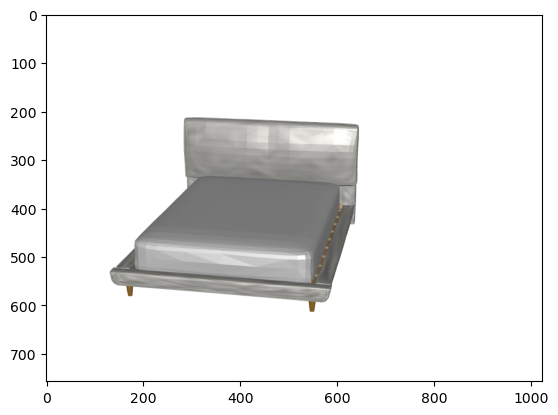

In [10]:
padded_img = np.concatenate((img, np.ones((img.shape[0], 1024 - img.shape[1], 4), dtype=np.uint8) * 255), axis = 1)[:, :, :-1]
plt.imshow(padded_img)
plt.show()

In [5]:
from SAM import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="./SAM/MODEL/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
predictor.set_image(padded_img)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


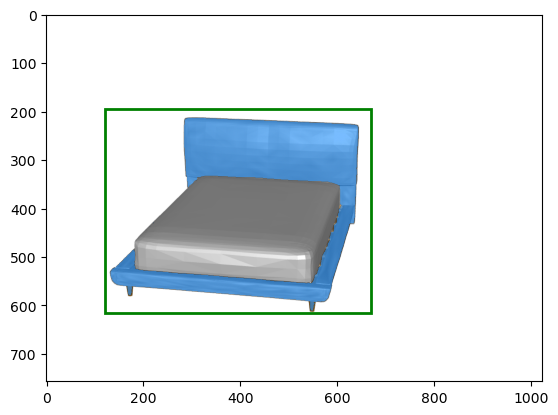

In [13]:
input_box = np.array([120, 195, 670, 615])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(img)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()

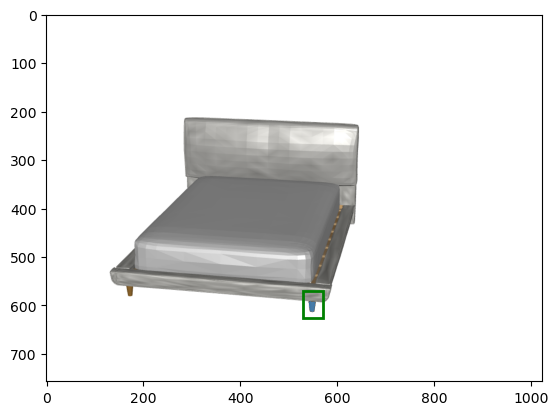

In [7]:
input_box = np.array([530, 570, 570, 625])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(img)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()

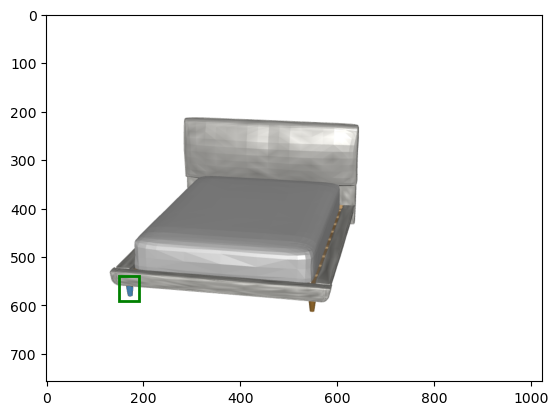

In [8]:
input_box = np.array([150, 540, 190, 590])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)
plt.figure()
plt.imshow(img)
show_box(input_box, plt.gca())
show_mask(masks[0], plt.gca())
plt.show()